In [1]:
"""
Analysis and Visualization Notebook.
This notebook performs exploratory data analysis and creates visualizations regarding the connection of taxi, subway and weather data.
"""

'\nAnalysis and Visualization Notebook.\nThis notebook performs exploratory data analysis and creates visualizations regarding the connection of taxi, subway and weather data.\n'

In [ ]:
import os
from functools import reduce
from itertools import product
import branca.colormap as cm
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

In [3]:
# Coordinates for map centring (from maps.google.com)
COORD_DICT = {
    "Manhattan": (40.7831, -73.9712),
    "Queens": (40.7282, -73.7949),
    "Brooklyn": (40.6782, -73.9442),
    "Bronx": (40.8448, -73.8648),
    "Staten Island": (40.5795, -74.1502),
    "EWR": (40.6895, -74.1745),
}

In [4]:
# Create session
spark = (
    SparkSession.builder.appName("Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "America/New_York")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "16g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/30 18:36:25 WARN Utils: Your hostname, JamesNsPC, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/30 18:36:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 18:36:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Taxi Analysis

Remember data is grouped hourly by pickup location

In [5]:
# Read in dataset
TAXI_DIR = "../data/curated/taxi_data/aggregated"
taxi_agg = spark.read.option("recursiveFileLookup", "true").parquet(TAXI_DIR)

In [6]:
for item in taxi_agg.schema:
    print(item)

StructField('PULocationID', LongType(), True)
StructField('pickup_datetime_hour', TimestampType(), True)
StructField('trips', LongType(), True)
StructField('total_fare_amount', DoubleType(), True)
StructField('total_amount_sum', DoubleType(), True)
StructField('median_total_amount', DoubleType(), True)
StructField('mean_total_amount', DoubleType(), True)
StructField('median_trip_distance', DoubleType(), True)
StructField('mean_trip_distance', DoubleType(), True)
StructField('median_trip_duration', DoubleType(), True)
StructField('mean_trip_duration', DoubleType(), True)
StructField('avg_passenger_count', DoubleType(), True)
StructField('total_tip_amount', DoubleType(), True)
StructField('total_tolls_amount', DoubleType(), True)
StructField('total_extra', DoubleType(), True)
StructField('total_improvement_surcharge', DoubleType(), True)
StructField('total_mta_tax', DoubleType(), True)
StructField('pct_within_borough_trip', DoubleType(), True)
StructField('is_weekend', BooleanType(), Tru

In [7]:
# Print if PuBorough is "Unknown"
if taxi_agg.filter(F.col("PUBorough") == "Unknown").count() > 0:
    print("unknown")

We will focus on total_amount during analysis, other features will be retained for modelling. 

In [8]:
# Attributes of interest
taxi_aoi = ["trips", "total_amount_sum", "median_trip_distance", "median_trip_duration"]


#### Distribution Analysis

This is primarily to inspect how our outlier analysis worked and ensure we are ready for graphing and further analysis. Likely won't be reported on

Summary for trips:
+-------+-----------------+
|summary|            trips|
+-------+-----------------+
|  count|          2292624|
|   mean|16.58585446196149|
| stddev| 51.2051823674719|
|    min|                0|
|    max|             1059|
+-------+-----------------+



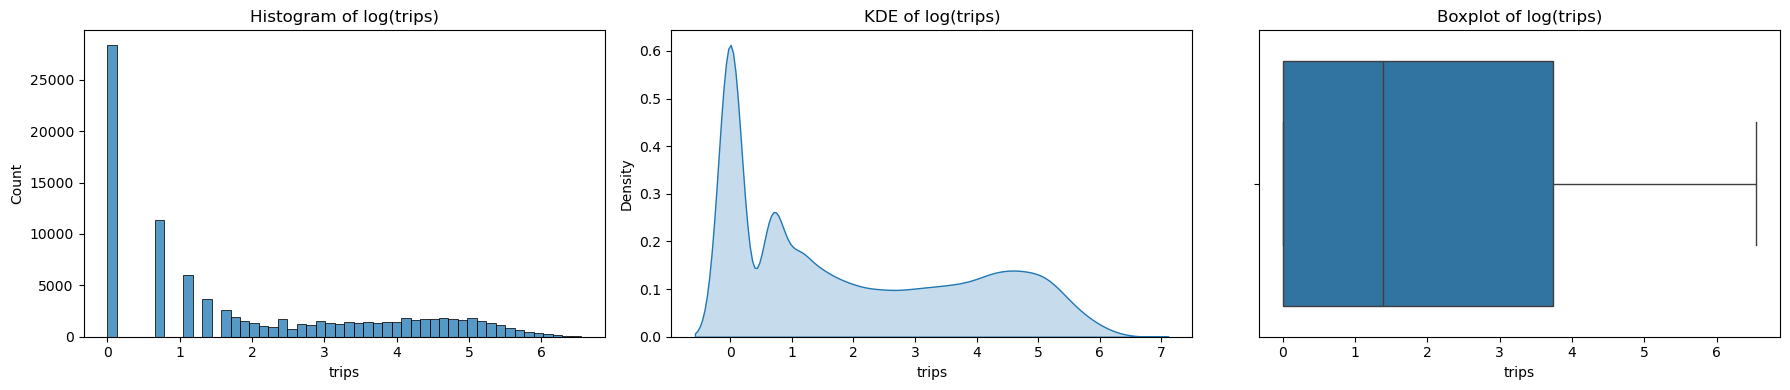

Summary for total_amount_sum:
+-------+------------------+
|summary|  total_amount_sum|
+-------+------------------+
|  count|           2292624|
|   mean| 459.0366209243131|
| stddev|1698.3299121179932|
|    min|               0.0|
|    max| 47516.87000000001|
+-------+------------------+



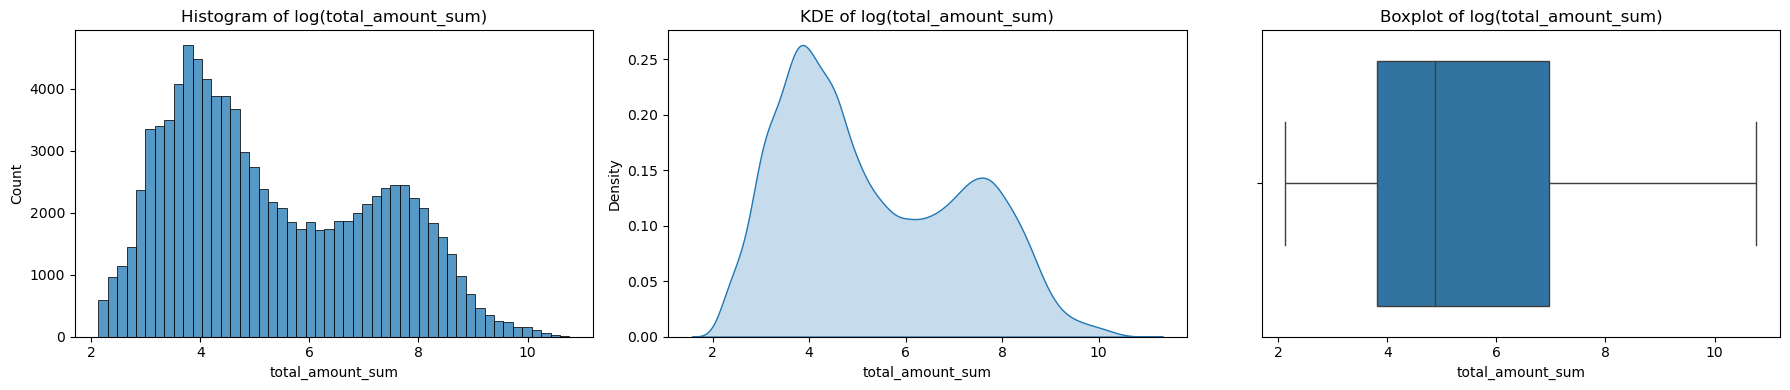

Summary for median_trip_distance:
+-------+--------------------+
|summary|median_trip_distance|
+-------+--------------------+
|  count|             2292624|
|   mean|   1.752634623034559|
| stddev|   3.283498623416528|
|    min|                 0.0|
|    max|               27.07|
+-------+--------------------+



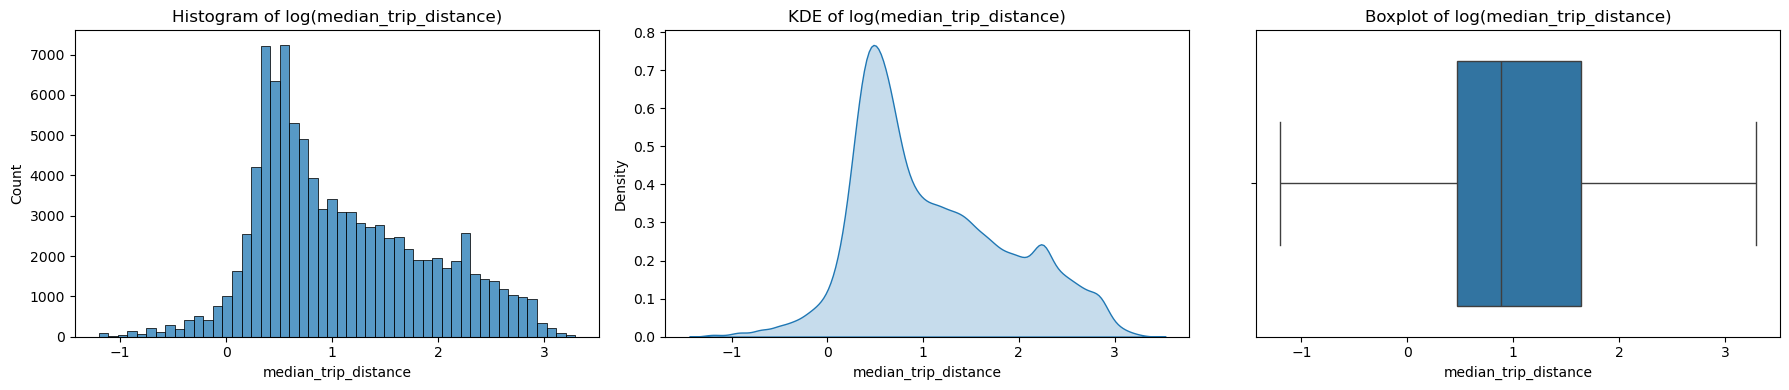

Summary for median_trip_duration:
+-------+--------------------+
|summary|median_trip_duration|
+-------+--------------------+
|  count|             2292624|
|   mean|    8.18338896827391|
| stddev|  13.252663089161198|
|    min|                 0.0|
|    max|   81.33333333333333|
+-------+--------------------+



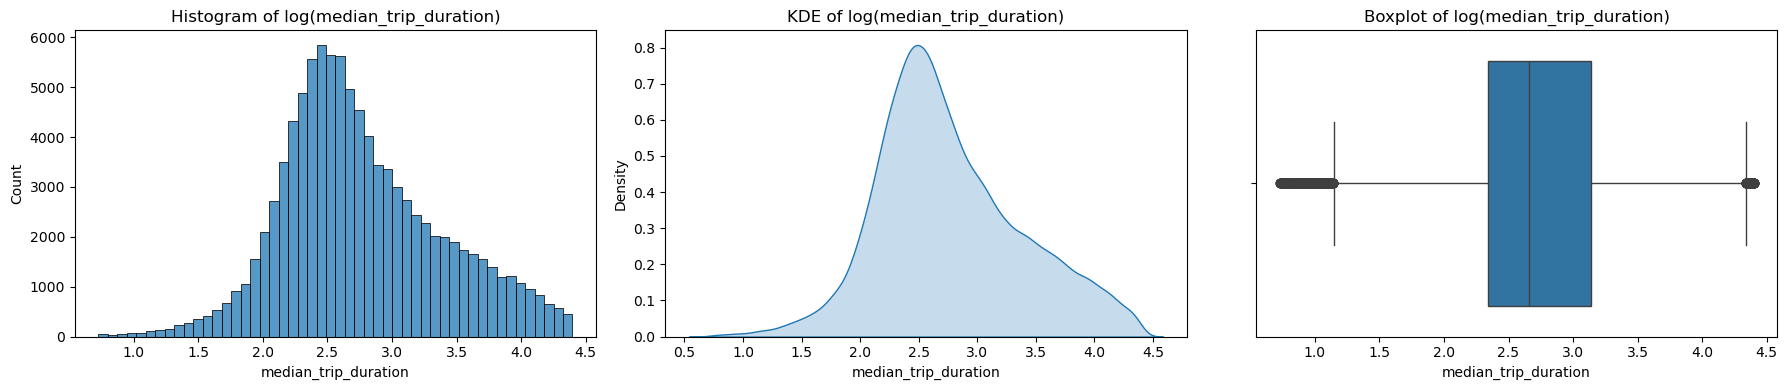

In [9]:
# Distribution (extreme outliers already removed in preprocessing)
def analyse_sdf(sdf, cols, sample_frac=0.1, logt=True):
    """
    Show summary statistics and log distribution plots for each column in cols from a Spark DataFrame.
    Args:
        sdf: Spark DataFrame
        cols: list of column names to analyze
        sample_frac: fraction of data to sample for plotting
        logt: whether to log-transform the data
    """
    for col in cols:
        print(f"Summary for {col}:")
        sdf.select(col).describe().show()
        pd_col = (
            sdf.select(col)
            .dropna()
            .sample(fraction=sample_frac, seed=1462474)
            .toPandas()
        )
        if logt:
            # Log-transform (add small constant to avoid log(0))
            plot_col = np.log(pd_col[col][pd_col[col] > 0])
            hist_title = f"Histogram of log({col})"
            kde_title = f"KDE of log({col})"
            box_title = f"Boxplot of log({col})"
        else:
            plot_col = pd_col[col]
            hist_title = f"Histogram of {col}"
            kde_title = f"KDE of {col}"
            box_title = f"Boxplot of {col}"
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        # Histogram
        sns.histplot(plot_col, bins=50, ax=axes[0], kde=False)
        axes[0].set_title(hist_title)
        # KDE plot
        sns.kdeplot(plot_col, ax=axes[1], fill=True)
        axes[1].set_title(kde_title)
        # Boxplot
        sns.boxplot(x=plot_col, ax=axes[2])
        axes[2].set_title(box_title)
        plt.tight_layout()
        plt.show()


# Call function

analyse_sdf(taxi_agg, taxi_aoi, sample_frac=0.1, logt=True)

## Subway Analysis

In [10]:
# Read in subway data
subway_sdf = spark.read.parquet("../data/curated/subway_data")

In [11]:
subway_sdf.printSchema

<bound method DataFrame.printSchema of +------------------+----------------+-------+---------+---------+--------------------+-------------------+
|station_complex_id|hourly_ridership|borough| latitude|longitude|        georeference|               hour|
+------------------+----------------+-------+---------+---------+--------------------+-------------------+
|                 1|            1342| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-02 07:00:00|
|                 1|              20| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-03 03:00:00|
|                 1|             245| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-04 05:00:00|
|                 1|             419| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-05 11:00:00|
|                 1|               9| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-06 03:00:00|
|                 1|              97| Queens|40.775036|-73.91203|POINT (-73.91203 ...|2024-01-06 06:00:00

In [12]:
# Analyse sdf
# Cols of interest:
subway_aoi = [
    "hourly_ridership",
]

Summary for hourly_ridership:
+-------+-----------------+
|summary| hourly_ridership|
+-------+-----------------+
|  count|          3649615|
|   mean|330.4401573864641|
| stddev|704.1533521154084|
|    min|                1|
|    max|            21479|
+-------+-----------------+



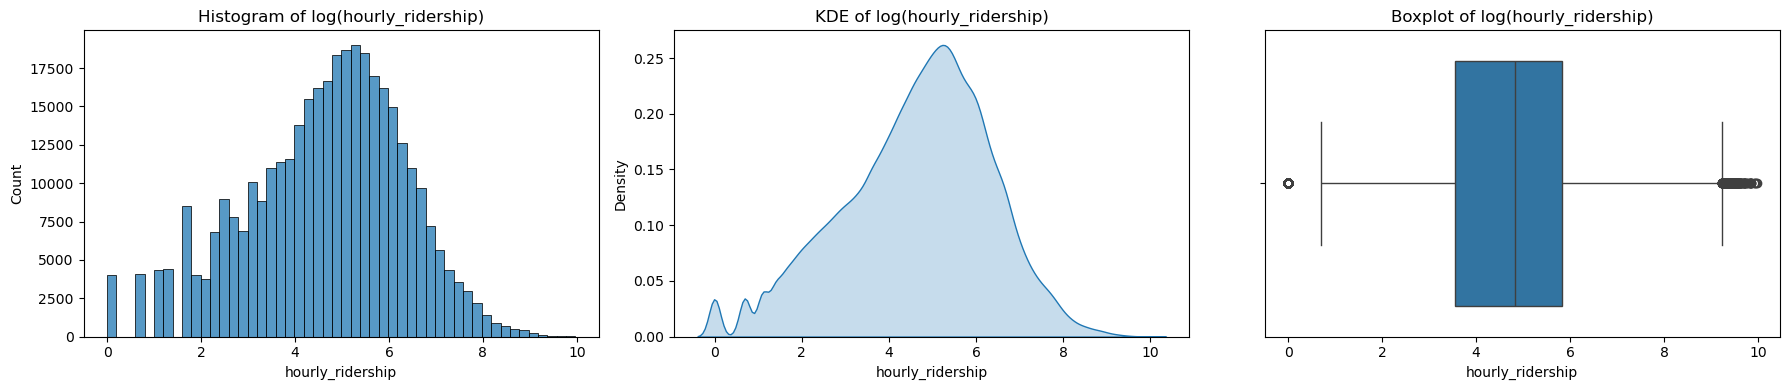

In [ ]:
# Analyze subway ridership data
analyse_sdf(subway_sdf, subway_aoi)

#### Show what times subway demand is low

([<matplotlib.axis.XTick at 0x7f7b4e405bd0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

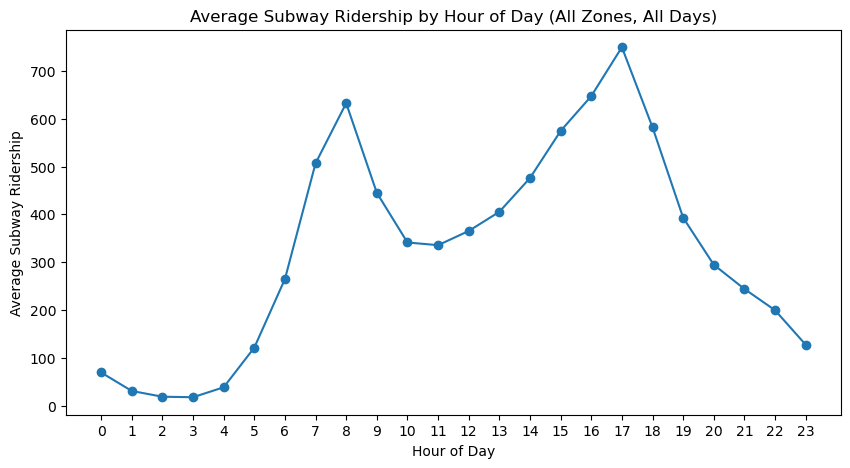

In [ ]:
# Group by hour of day, average across all days and zones
subway_hourly_avg = (
    subway_sdf.withColumn("hour_of_day", F.hour("hour"))
    .groupBy("hour_of_day")
    .agg(F.mean("hourly_ridership").alias("avg_hourly_ridership"))
    .orderBy("hour_of_day")
    .toPandas()
)
# Plot the average ridership by hour
plt.figure(figsize=(10, 5))
plt.plot(
    subway_hourly_avg["hour_of_day"],
    subway_hourly_avg["avg_hourly_ridership"],
    marker="o",
)
plt.xlabel("Hour of Day")
plt.ylabel("Average Subway Ridership")
plt.title("Average Subway Ridership by Hour of Day (All Zones, All Days)")
plt.xticks(range(0, 24))

## Weather Analysis

In [15]:
weather_sdf = spark.read.parquet("../data/curated/weather_data")

In [16]:
# Show weatehr cols
weather_sdf.printSchema()

root
 |-- apparent_temperature: double (nullable = true)
 |-- cloud_cover: long (nullable = true)
 |-- direct_radiation: double (nullable = true)
 |-- is_day: long (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- relative_humidity_2m: long (nullable = true)
 |-- shortwave_radiation: double (nullable = true)
 |-- snow_depth: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- surface_pressure: double (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- weather_code: long (nullable = true)
 |-- wind_gusts_10m: double (nullable = true)
 |-- wind_speed_10m: double (nullable = true)
 |-- BoroName: string (nullable = true)
 |-- is_clear: boolean (nullable = true)
 |-- is_cloudy: boolean (nullable = true)
 |-- is_rain: boolean (nullable = true)
 |-- is_snow: boolean (nullable = true)
 |-- is_thunderstorm: boolean 

Summary for temperature_2m:
+-------+------------------+
|summary|    temperature_2m|
+-------+------------------+
|  count|             52704|
|   mean|12.926572935640587|
| stddev| 9.602738892996928|
|    min|             -14.7|
|    max|              36.3|
+-------+------------------+



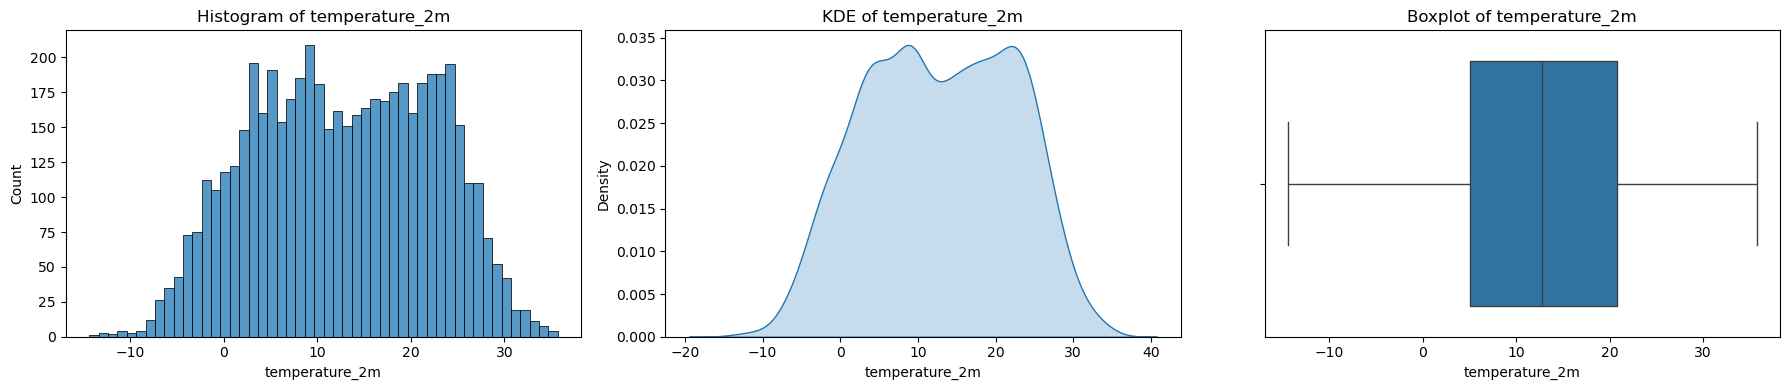

Summary for precipitation:
+-------+-------------------+
|summary|      precipitation|
+-------+-------------------+
|  count|              52704|
|   mean|0.14303658166362856|
| stddev| 0.7385239416457218|
|    min|                0.0|
|    max|               24.3|
+-------+-------------------+



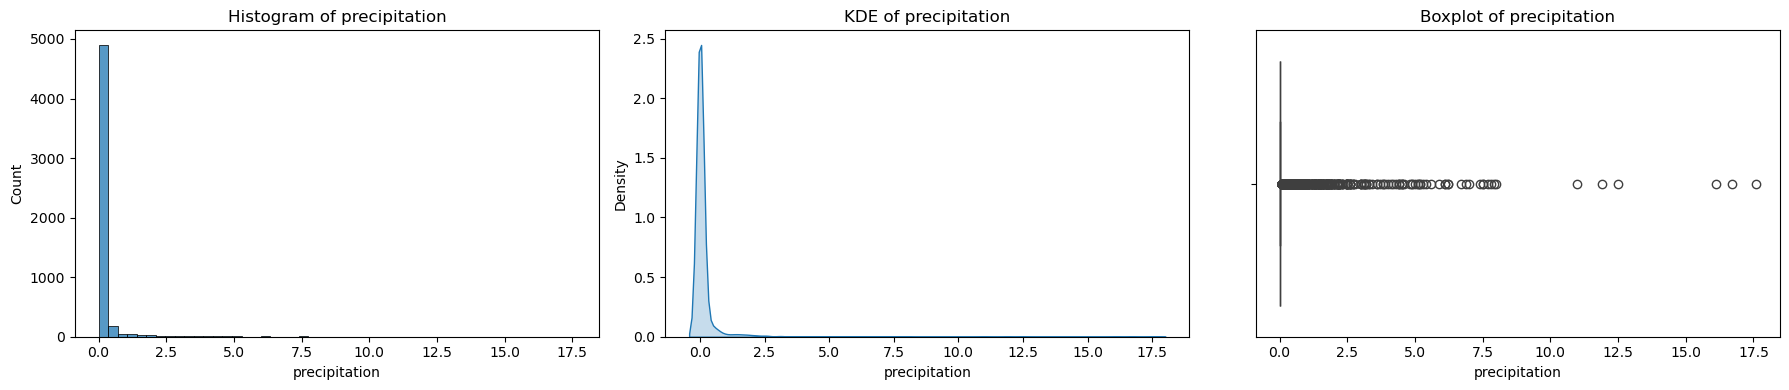

Summary for relative_humidity_2m:
+-------+--------------------+
|summary|relative_humidity_2m|
+-------+--------------------+
|  count|               52704|
|   mean|    68.9082422586521|
| stddev|  18.929006153544623|
|    min|                  15|
|    max|                 100|
+-------+--------------------+



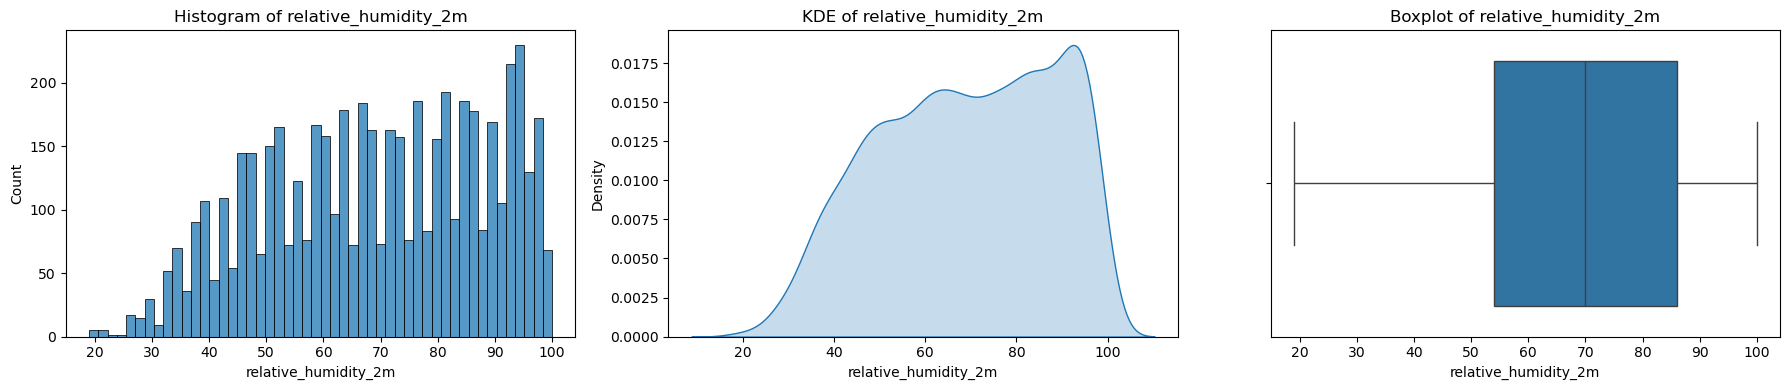

In [17]:
weather_aoi = ["temperature_2m", "precipitation", "relative_humidity_2m"]
analyse_sdf(weather_sdf, weather_aoi, logt=False)

# Interaction 

### Joining the Datasets

First we assign each subway station to a taxi zone

In [18]:
# Load taxi zones shapefile (polygons)
taxi_zones = gpd.read_file("../data/import_csvs/taxi_zones/shapefiles/taxi_zones.shp")

# Load subway stations lookup
subway_stations = pd.read_csv("../data/curated/lookup/station_lookup.csv")


# Create GeoDataFrame with correct original CRS (EPSG:4326)
subway_stations = gpd.GeoDataFrame(
    subway_stations,
    geometry=gpd.GeoSeries.from_wkt(subway_stations["Georeference"]),
    crs="EPSG:4326",
)

# Project to taxi_zones CRS
subway_stations = subway_stations.to_crs(taxi_zones.crs)
subway_stations.crs = taxi_zones.crs

# Buffer taxi zones by a small distance as some stations are on borders
taxi_zones_buffered = taxi_zones.copy()
taxi_zones_buffered["geometry"] = taxi_zones_buffered.geometry.buffer(10)

# Spatial join using buffered polygons
stations_with_zone = gpd.sjoin(
    subway_stations, taxi_zones_buffered, how="left", predicate="within"
)

# Add the taxi zone column to subway_sdf
zone_lookup = stations_with_zone[["station_complex_id", "LocationID"]]

# Convert to Spark DataFrame for joining
zone_lookup_sdf = spark.createDataFrame(zone_lookup)

# Join with subway_sdf on station_complex_id
subway_sdf = subway_sdf.join(zone_lookup_sdf, on="station_complex_id", how="left")

In [19]:
# Load taxi zone lookup for visualisations as Spark DataFrame
taxi_lu = spark.read.csv(
    "../data/import_csvs/taxi_zones/taxi_zone_lookup.csv", header=True
)

taxi_agg = taxi_agg.withColumnRenamed("PULocationID", "LocationID")

# Join to taxi_agg using Spark join
taxi_agg = taxi_agg.join(
    taxi_lu.select("LocationID", "Zone"), on="LocationID", how="left"
).drop(taxi_lu["LocationID"])

# Rename Zone to lower
taxi_agg = taxi_agg.withColumnRenamed("Zone", "zone")


Let's saturate time/zone combinations that don't exist with 0's to ensure we do not lose records.

In [20]:
subway_sdf.columns

['station_complex_id',
 'hourly_ridership',
 'borough',
 'latitude',
 'longitude',
 'georeference',
 'hour',
 'LocationID']

In [21]:
# Aggregate subway data by LocationID (zone) and hour
subway_zone_hour_agg = subway_sdf.groupBy("LocationID", "hour").agg(
    F.sum("hourly_ridership").alias("hourly_ridership"),
)

# We need a saturated subway sdf so we can make lag features later

# Get all unique LocationIDs and all unique hours from taxi_agg
location_ids = [
    row["LocationID"] for row in taxi_agg.select("LocationID").distinct().collect()
]
hours = [
    row["pickup_datetime_hour"]
    for row in taxi_agg.select("pickup_datetime_hour").distinct().collect()
]

# Create a complete grid DataFrame
grid = spark.createDataFrame(
    [(loc, hr) for loc, hr in product(location_ids, hours)],
    schema=["LocationID", "hour"],
)

# Left join subway_zone_hour_agg onto the grid
subway_zone_hour_agg_saturated = grid.join(
    subway_zone_hour_agg, ["LocationID", "hour"], how="left"
).fillna({"hourly_ridership": 0})

# Use subway_zone_hour_agg_saturated for joining with taxi_agg
taxi_subway = (
    taxi_agg.join(
        subway_zone_hour_agg_saturated,
        (taxi_agg.LocationID == subway_zone_hour_agg_saturated.LocationID)
        & (taxi_agg.pickup_datetime_hour == subway_zone_hour_agg_saturated.hour),
        how="left",
    )
    .drop(subway_zone_hour_agg_saturated["LocationID"])
    .drop(subway_zone_hour_agg_saturated["hour"])
)

taxi_subway = taxi_subway.fillna({"hourly_ridership": 0})

In [22]:
taxi_subway.show(10)

25/08/30 18:37:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/08/30 18:37:18 WARN TaskSetManager: Stage 54 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-----+-----------------+----------------+-------------------+-----------------+--------------------+------------------+--------------------+------------------+-------------------+----------------+------------------+-----------+---------------------------+-------------+-----------------------+----------+------+-------+-----------+------------+-----+-----------+---------+--------------+----------------+
|LocationID|pickup_datetime_hour|trips|total_fare_amount|total_amount_sum|median_total_amount|mean_total_amount|median_trip_distance|mean_trip_distance|median_trip_duration|mean_trip_duration|avg_passenger_count|total_tip_amount|total_tolls_amount|total_extra|total_improvement_surcharge|total_mta_tax|pct_within_borough_trip|is_weekend|season|quarter|pickup_hour|week_of_year|month|day_of_week|PUBorough|          zone|hourly_ridership|
+----------+--------------------+-----+-----------------+----------------+-------------------+-----------------+------------

In [23]:
# Join weather
final_sdf = taxi_subway.join(
    weather_sdf,
    (taxi_subway.PUBorough == weather_sdf.BoroName)
    & (taxi_subway.pickup_datetime_hour == weather_sdf.datetime_hour),
    how="left",
)

In [24]:
weather_sdf.columns

['apparent_temperature',
 'cloud_cover',
 'direct_radiation',
 'is_day',
 'precipitation',
 'rain',
 'relative_humidity_2m',
 'shortwave_radiation',
 'snow_depth',
 'snowfall',
 'sunshine_duration',
 'surface_pressure',
 'temperature_2m',
 'timestamp',
 'weather_code',
 'wind_gusts_10m',
 'wind_speed_10m',
 'BoroName',
 'is_clear',
 'is_cloudy',
 'is_rain',
 'is_snow',
 'is_thunderstorm',
 'is_extreme_heat',
 'is_extreme_cold',
 'precip_intensity',
 'humidity_level',
 'is_windy',
 'datetime_hour']

In [25]:
# Merge taxi and weather, keeping all taxi records
taxi_weather_sdf = taxi_agg.join(
    weather_sdf,
    (taxi_agg.PUBorough == weather_sdf.BoroName)
    & (taxi_agg.pickup_datetime_hour == weather_sdf.datetime_hour),
    how="left",
)


In [26]:
# Print any records with nulls

null_condition = reduce(
    lambda a, b: a | b, [F.col(c).isNull() for c in taxi_weather_sdf.columns]
)
null_records = taxi_weather_sdf.filter(null_condition)
null_records.show(50)

+----------+--------------------+-----+-----------------+----------------+-------------------+-----------------+--------------------+------------------+--------------------+------------------+-------------------+----------------+------------------+-----------+---------------------------+-------------+-----------------------+----------+------+-------+-----------+------------+-----+-----------+-------------+--------------------+--------------------+-----------+----------------+------+-------------+----+--------------------+-------------------+----------+--------+-----------------+----------------+--------------+---------+------------+--------------+--------------+--------+--------+---------+-------+-------+---------------+---------------+---------------+----------------+--------------+--------+-------------+
|LocationID|pickup_datetime_hour|trips|total_fare_amount|total_amount_sum|median_total_amount|mean_total_amount|median_trip_distance|mean_trip_distance|median_trip_duration|mean_trip

In [27]:
taxi_weather_sdf.count()

2292885

In [28]:
taxi_subway.count()

25/08/30 18:37:25 WARN TaskSetManager: Stage 71 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


2292624

In [29]:
final_sdf.count()

25/08/30 18:37:27 WARN TaskSetManager: Stage 81 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


2292885

### Feature Engineering

In [30]:
# Taxi-to-subway trips ratio
# Captures relative taxi demand compared to subway ridership
# Avoid div by 0
taxi_subway = taxi_subway.withColumn(
    "taxi_subway_ratio",
    F.when(
        F.col("hourly_ridership") != 0, F.col("trips") / F.col("hourly_ridership")
    ).otherwise(None),
)

# Revenue share within the hour
# Shows zone contribution to total revenue in that hour
w_hour = Window.partitionBy("pickup_datetime_hour")
taxi_subway = taxi_subway.withColumn(
    "revenue_share_zone",
    F.when(
        F.sum("total_amount_sum").over(w_hour) != 0,
        F.col("total_amount_sum") / F.sum("total_amount_sum").over(w_hour),
    ).otherwise(None),
)

# Add this to the Feature Engineering stage
taxi_subway = taxi_subway.withColumn(
    "median_revenue_per_minute",
    F.when(
        F.col("median_trip_duration") != 0,
        F.col("total_amount_sum") / F.col("median_trip_duration"),
    ).otherwise(None),
)


# Final_sdf (for modelling) will include all these features after the join below
final_sdf = taxi_subway.join(
    weather_sdf,
    (taxi_subway.PUBorough == weather_sdf.BoroName)
    & (taxi_subway.pickup_datetime_hour == weather_sdf.datetime_hour),
    how="left",
)

# Analysis only feature
analysis_only_cols = ["revenue_share_zone"]
final_sdf = final_sdf.drop(*analysis_only_cols)

# Fill these with 0 as it is meaningful (trie ratio or median is 0 not null)
final_sdf = final_sdf.fillna({"median_revenue_per_minute": 0, "taxi_subway_ratio": 0})


In [31]:
# final_sdf.show(5)

## Graphing & Analysis

Calculate volatility and look for trends in the taxi-subway ratio over time.

In [32]:
# Add hour_of_day column
taxi_subway = taxi_subway.withColumn("hour_of_day", F.hour("pickup_datetime_hour"))

# Calculate mean and std by zone and hour (to capture hourly variation)
zone_hour_stats = taxi_subway.groupBy("LocationID", "hour_of_day").agg(
    F.mean("taxi_subway_ratio").alias("mean_ratio_hour"),
    F.stddev("taxi_subway_ratio").alias("std_ratio_hour"),
)

# Join back to main DataFrame
taxi_subway = taxi_subway.join(
    zone_hour_stats, on=["LocationID", "hour_of_day"], how="left"
)

# Calculate hour-specific residual (z-score)
taxi_subway = taxi_subway.withColumn(
    "ratio_residual",
    F.when(
        F.col("std_ratio_hour") > 0,
        (F.col("taxi_subway_ratio") - F.col("mean_ratio_hour"))
        / F.col("std_ratio_hour"),
    ).otherwise(F.lit(0.0)),
)


In [33]:
# Flag anomalies per zone and hour, but only for hours with subway count > 20 to reduce noise
taxi_subway_filtered = taxi_subway.filter(F.col("hourly_ridership") > 20)

taxi_subway_filtered = taxi_subway_filtered.withColumn(
    "is_high_anomaly", F.when(F.col("ratio_residual") > 1, 1).otherwise(0)
)

# Calculate zone-level mean and std, and the proportion of hours that are high anomalies for each zone
zone_anomaly_stats = (
    taxi_subway_filtered.groupBy("LocationID")
    .agg(
        F.mean("is_high_anomaly").alias("high_anomaly_rate"),
        F.count("*").alias("n_hours"),
    )
    .orderBy(F.desc("high_anomaly_rate"))
)

# Attach zone name using lookup
if "taxi_zones" in locals() and not isinstance(taxi_zones, pd.DataFrame):
    taxi_zones_pd = taxi_zones.select("LocationID", "zone").toPandas()

zone_anomaly_pd = zone_anomaly_stats.toPandas()
zone_anomaly_pd = zone_anomaly_pd.merge(taxi_zones, on="LocationID", how="left")
print(zone_anomaly_pd[["zone", "high_anomaly_rate"]][:10])

25/08/30 18:37:30 WARN TaskSetManager: Stage 92 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


                      zone  high_anomaly_rate
0             West Village           0.164138
1             Midtown East           0.161703
2  Greenwich Village South           0.160830
3              Murray Hill           0.160260
4      Little Italy/NoLiTa           0.159021
5            Midtown South           0.157180
6           Midtown Center           0.155812
7                 Flatiron           0.154329
8     TriBeCa/Civic Center           0.152162
9                 Union Sq           0.151249


#### Anomalies in Manhattan

In [ ]:
def plot_manhattan_anomaly_map(
    manhattan_zones,
    output_html="../visualisations/taxi_zones.html",
    map_center=None,
    zoom_start=12,
    colormap_caption="Anomaly Rate",
    map_title="Manhattan Taxi Zone High Anomaly Rate",
    season=None,
):
    """
    Plots the Manhattan taxi zone high anomaly rate map with a large, plain-text legend.
    Args:
        manhattan_zones (GeoDataFrame): The GeoDataFrame containing Manhattan taxi zones and their anomaly rates.
        output_html (str): The file path to save the output HTML map.
        map_center (tuple): The latitude and longitude to center the map.
        zoom_start (int): The initial zoom level for the map.
        colormap_caption (str): The caption for the colormap legend.
        map_title (str): The title for the map.
        season (str): The season to filter the data (optional).
    """

    # Compute anomaly quantiles for colormap
    lower = manhattan_zones["anomaly"].quantile(0.10)
    upper = manhattan_zones["anomaly"].quantile(0.90)

    # Create colormap
    colormap = cm.StepColormap(
        colors=["#deebf7", "#a9cee1", "#7ab7da", "#3374a2", "#003e7b"],
        vmin=lower,
        vmax=upper,
        index=[
            lower,
            lower + (upper - lower) * 0.25,
            lower + (upper - lower) * 0.5,
            lower + (upper - lower) * 0.75,
            upper,
        ],
        caption=colormap_caption,
    )

    # Map dimensions
    map_width = "700px"

    # Title HTML visually grouped and centered with map
    title_html = f"""
    <div style="display:inline-block;width:{map_width};padding:0;margin:0;">
        <div style="width:{map_width};margin:0;padding:0;">
            <h2 style="font-size:28px;margin:0;padding:0;text-align:center;">
                <b>{map_title}{" - " + season if season else ""}</b>
            </h2>
        </div>
        <div style="height:10px;"></div> 
    </div>
    """

    # Create the map object
    m = folium.Map(
        location=map_center,
        zoom_start=zoom_start,
        tiles="cartodbpositron",
        width=map_width,
        height=map_width,
    )

    # Add the title directly above the map, centered, with extra space below
    m.get_root().html.add_child(folium.Element(title_html))

    # Add the GeoJson layer
    folium.GeoJson(
        manhattan_zones,
        # Add a custom style function
        style_function=lambda feature: {
            "fillColor": "#cccccc"
            if pd.isna(feature["properties"]["anomaly"])
            else colormap(feature["properties"]["anomaly"]),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.7
            if not pd.isna(feature["properties"]["anomaly"])
            else 0.3,
            "dashArray": "5, 5" if pd.isna(feature["properties"]["anomaly"]) else None,
        },
        # Add a tooltip
        tooltip=folium.features.GeoJsonTooltip(
            fields=["zone", "anomaly"],
            aliases=["Zone:", "High Anomaly Rate:"],
            localize=True,
        ),
        name="Zones",
    ).add_to(m)

    # Add the colormap legend (styled)
    colormap.add_to(m)

    # Add CSS for legend font size (caption and ticks)
    legend_css = """
    <style>
    .legend .caption {font-size: 18px !important; font-weight: bold;}
    .legend .tick {font-size: 16px !important;}
    </style>
    """
    # Add CSS for map title font size
    m.get_root().html.add_child(folium.Element(legend_css))

    # Add layer control
    folium.LayerControl().add_to(m)

    # Create output and save 
    os.makedirs(os.path.dirname(output_html), exist_ok=True)
    m.save(output_html)
    print(f"Map saved to {output_html}")

In [35]:
# Load taxi zones shapefile and filter for Manhattan
taxi_zones_gdf = taxi_zones.copy()
manhattan_zones = taxi_zones_gdf[taxi_zones_gdf["borough"] == "Manhattan"].copy()

# We are only using high anomaly rate, 'anomaly'. As there were negligible demand loss anomalies.
zone_anomaly_pd["anomaly"] = zone_anomaly_pd["high_anomaly_rate"]

# Merge zone name and anomaly info into Manhattan zones
manhattan_zones = manhattan_zones.merge(
    zone_anomaly_pd[["LocationID", "anomaly", "zone", "high_anomaly_rate"]],
    left_on="LocationID",
    right_on="LocationID",
    how="left",
)

# Ensure the zone name is available for the tooltip
if "zone_y" in manhattan_zones.columns:
    manhattan_zones = manhattan_zones.rename(columns={"zone_y": "zone"})
if "zone_x" in manhattan_zones.columns:
    manhattan_zones = manhattan_zones.drop(columns=["zone_x"])


# Call function
plot_manhattan_anomaly_map(
    manhattan_zones,
    output_html="../visualisations/taxi_zones.html",
    map_center=COORD_DICT["Manhattan"],
    map_title="Manhattan Taxi Zone High Anomaly Rate",
)

Map saved to ../visualisations/taxi_zones.html


#### Print the hours that anomalies occur

Just to show our anomalies aren't skewed by hour

25/08/30 18:37:38 WARN TaskSetManager: Stage 133 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.
25/08/30 18:37:38 WARN TaskSetManager: Stage 134 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


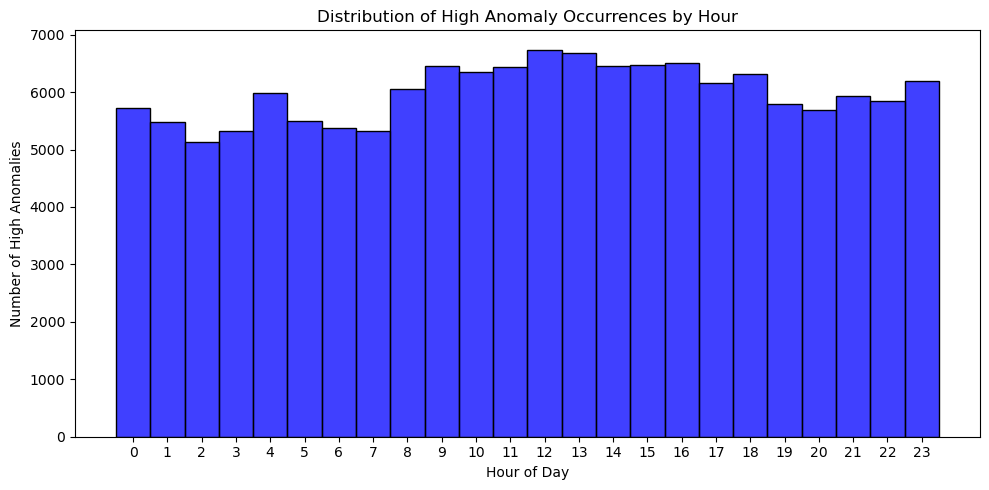

In [36]:
# Plot the distribution of hours when high anomalies occur

# Get the hours for all high anomalies (ratio_residual > 1)
anomaly_hours_pd = (
    taxi_subway.filter(F.col("ratio_residual") > 1)
    .select("pickup_datetime_hour")
    .dropna()
    .toPandas()
)

# Extract hour of day
anomaly_hours_pd["hour_of_day"] = pd.to_datetime(
    anomaly_hours_pd["pickup_datetime_hour"]
).dt.hour

plt.figure(figsize=(10, 5))
sns.histplot(anomaly_hours_pd["hour_of_day"], bins=24, discrete=True, color="blue")
plt.xlabel("Hour of Day")
plt.ylabel("Number of High Anomalies")
plt.title("Distribution of High Anomaly Occurrences by Hour")
plt.xticks(range(0, 24))
plt.tight_layout()

### Weather Visualisation

#### Histograms and boxplots per subway ridership quartile

25/08/30 18:37:49 WARN TaskSetManager: Stage 156 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.
25/08/30 18:37:54 WARN TaskSetManager: Stage 166 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


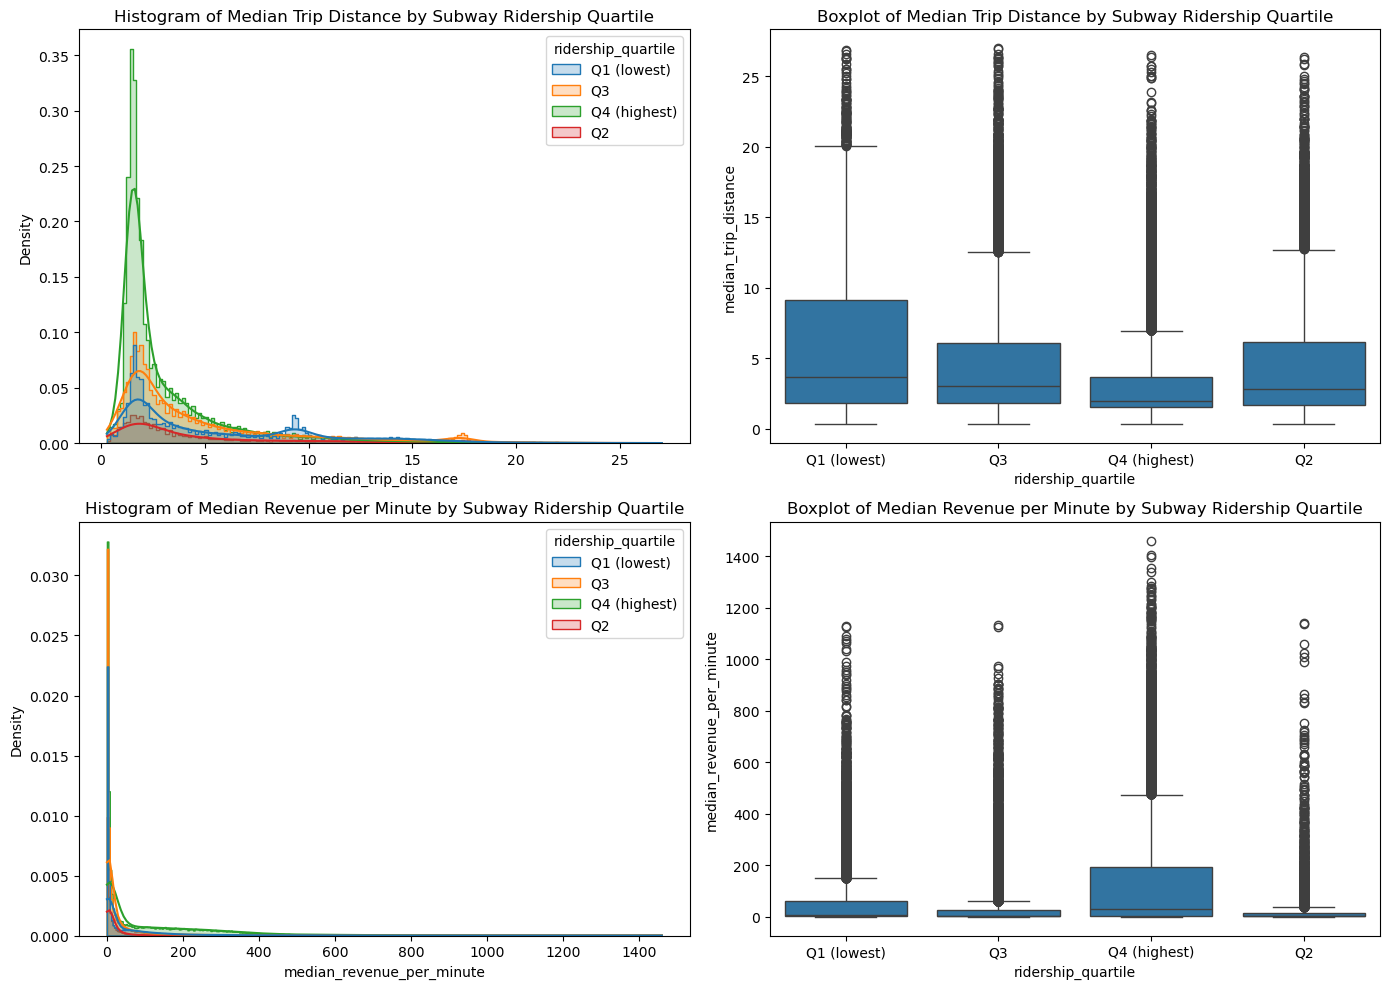

In [37]:
# Compute subway ridership quartiles
quartiles = taxi_subway.approxQuantile("hourly_ridership", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = quartiles

# Assign quartile labels
taxi_subway = taxi_subway.withColumn(
    "ridership_quartile",
    F.when(F.col("hourly_ridership") <= q1, "Q1 (lowest)")
    .when((F.col("hourly_ridership") > q1) & (F.col("hourly_ridership") <= q2), "Q2")
    .when((F.col("hourly_ridership") > q2) & (F.col("hourly_ridership") <= q3), "Q3")
    .otherwise("Q4 (highest)"),
)

# Convert to pandas for plotting
plot_pd = (
    taxi_subway.select(
        "median_trip_distance", "median_revenue_per_minute", "ridership_quartile"
    )
    .dropna()
    .sample(fraction=0.1, seed=1462474)
    .toPandas()
)

# Plot histograms/boxplots grouped by subway ridership quartile
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram: median_trip_distance
sns.histplot(
    data=plot_pd,
    x="median_trip_distance",
    hue="ridership_quartile",
    ax=axes[0, 0],
    kde=True,
    element="step",
    stat="density",
)
axes[0, 0].set_title("Histogram of Median Trip Distance by Subway Ridership Quartile")

# Boxplot: median_trip_distance
sns.boxplot(
    data=plot_pd, x="ridership_quartile", y="median_trip_distance", ax=axes[0, 1]
)
axes[0, 1].set_title("Boxplot of Median Trip Distance by Subway Ridership Quartile")

# Histogram: median_revenue_per_minute
sns.histplot(
    data=plot_pd,
    x="median_revenue_per_minute",
    hue="ridership_quartile",
    ax=axes[1, 0],
    kde=True,
    element="step",
    stat="density",
)
axes[1, 0].set_title(
    "Histogram of Median Revenue per Minute by Subway Ridership Quartile"
)

# Boxplot: median_revenue_per_minute
sns.boxplot(
    data=plot_pd, x="ridership_quartile", y="median_revenue_per_minute", ax=axes[1, 1]
)
axes[1, 1].set_title(
    "Boxplot of Median Revenue per Minute by Subway Ridership Quartile"
)

plt.tight_layout()
plt.show()

In [38]:
taxi_subway.columns

['LocationID',
 'hour_of_day',
 'pickup_datetime_hour',
 'trips',
 'total_fare_amount',
 'total_amount_sum',
 'median_total_amount',
 'mean_total_amount',
 'median_trip_distance',
 'mean_trip_distance',
 'median_trip_duration',
 'mean_trip_duration',
 'avg_passenger_count',
 'total_tip_amount',
 'total_tolls_amount',
 'total_extra',
 'total_improvement_surcharge',
 'total_mta_tax',
 'pct_within_borough_trip',
 'is_weekend',
 'season',
 'quarter',
 'pickup_hour',
 'week_of_year',
 'month',
 'day_of_week',
 'PUBorough',
 'zone',
 'hourly_ridership',
 'taxi_subway_ratio',
 'revenue_share_zone',
 'median_revenue_per_minute',
 'mean_ratio_hour',
 'std_ratio_hour',
 'ratio_residual',
 'ridership_quartile']

25/08/30 18:38:00 WARN TaskSetManager: Stage 175 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


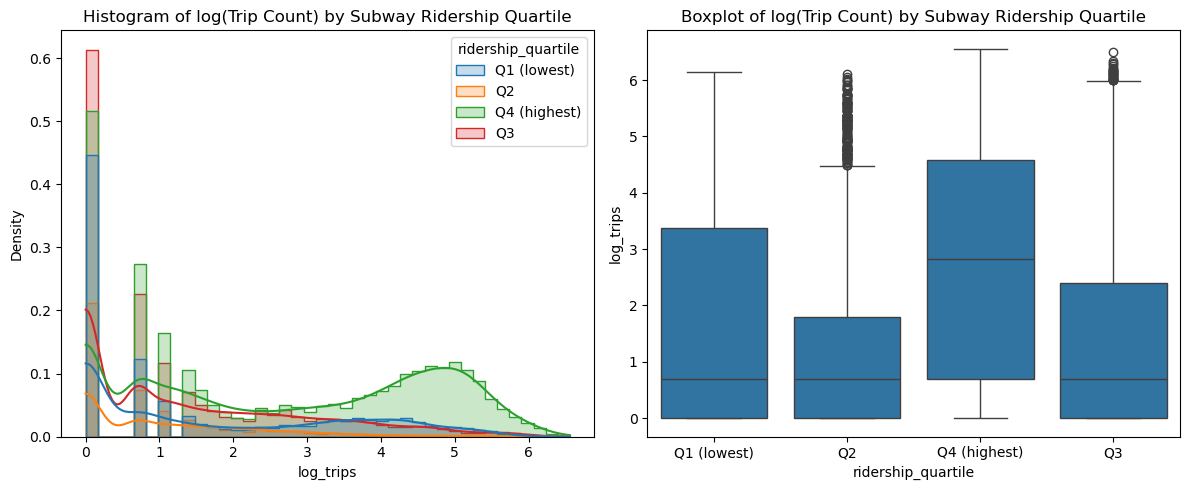

In [39]:
# Convert to pandas for plotting (log-transform trips)
plot_trips_pd = (
    taxi_subway.select("trips", "ridership_quartile")
    .dropna()
    .sample(fraction=0.1, seed=1462474)
    .toPandas()
)
plot_trips_pd = plot_trips_pd[plot_trips_pd["trips"] > 0].copy()  # avoid log(0)
plot_trips_pd["log_trips"] = np.log(plot_trips_pd["trips"])

# Plot histograms/boxplots grouped by subway ridership quartile for log(trips)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram: log(trips)
sns.histplot(
    data=plot_trips_pd,
    x="log_trips",
    hue="ridership_quartile",
    ax=axes[0],
    kde=True,
    element="step",
    stat="density",
)
axes[0].set_title("Histogram of log(Trip Count) by Subway Ridership Quartile")

# Boxplot: log(trips)
sns.boxplot(data=plot_trips_pd, x="ridership_quartile", y="log_trips", ax=axes[1])
axes[1].set_title("Boxplot of log(Trip Count) by Subway Ridership Quartile")

plt.tight_layout()
plt.show()
#

### Taxi Demand in Different Weather Conditions

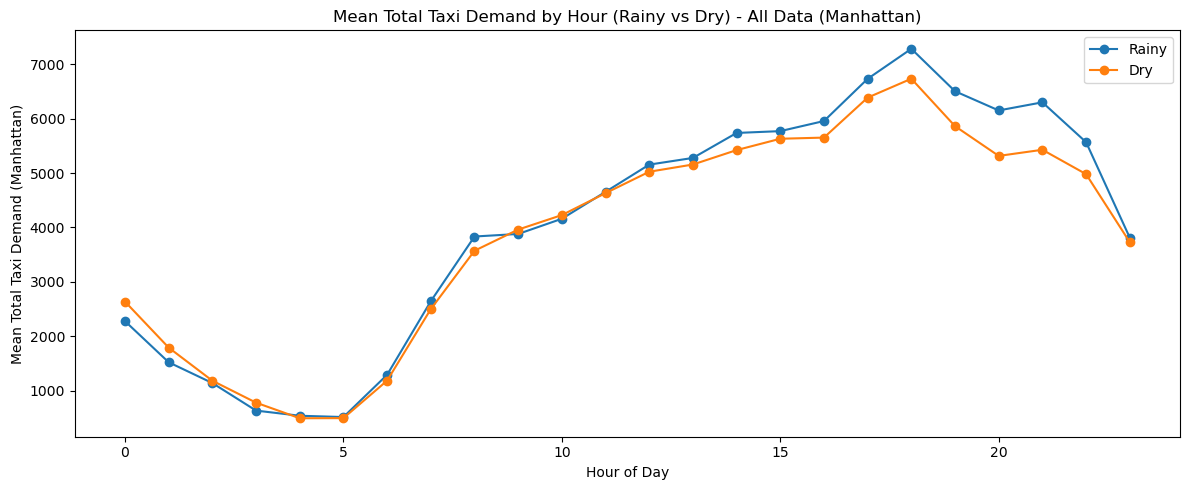

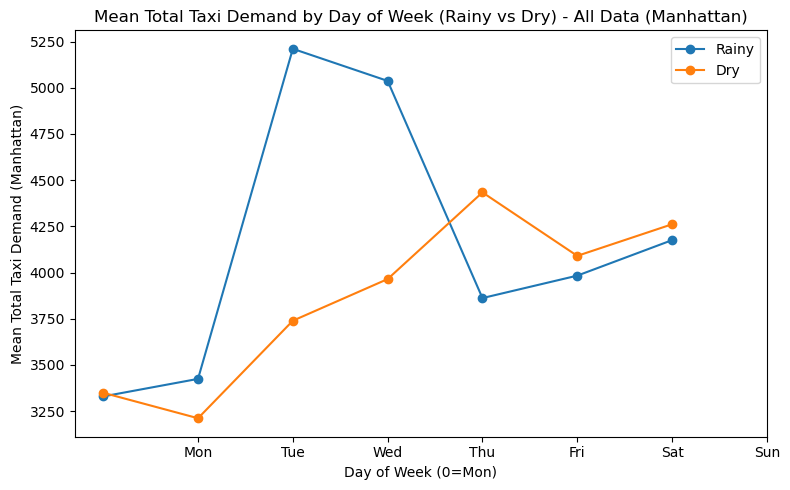

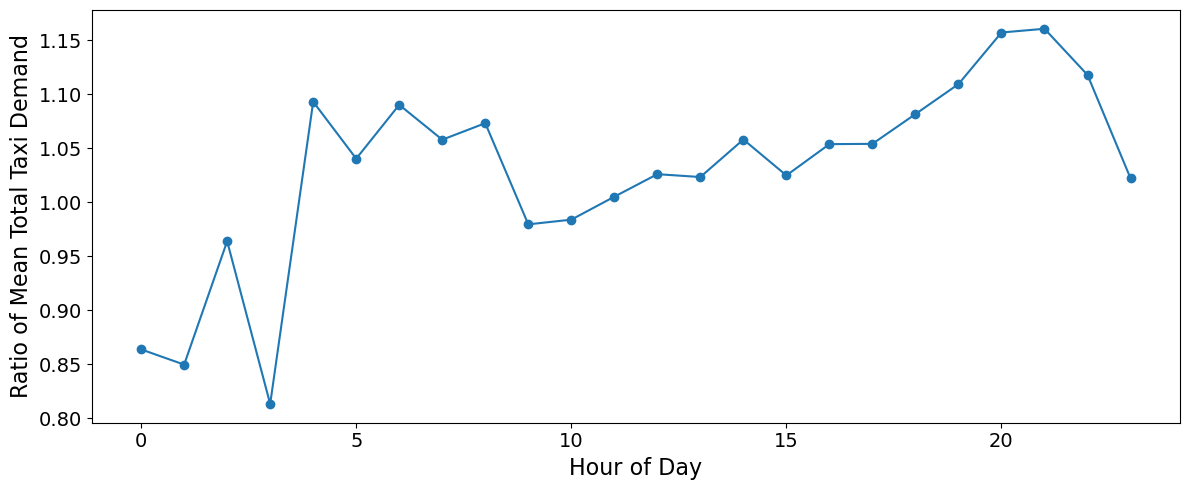

Mean demand increases by 4.9% (All Data)


In [40]:
# Plot for Manhattan only (may change later)
man_sdf = taxi_weather_sdf.filter(F.col("PUBorough") == "Manhattan")

# Add weather_type column
man_sdf = man_sdf.withColumn(
    "weather_type", F.when(F.col("is_rain"), F.lit("Rainy")).otherwise(F.lit("Dry"))
)

# Aggregate total demand per hour (sum over all locations)
total_hour_sdf = (
    man_sdf.groupBy("weather_type", "pickup_datetime_hour")
    .agg(F.sum("trips").alias("trips"))
    .withColumn("hour_of_day", F.hour("pickup_datetime_hour"))
    .withColumn("day_of_week", F.dayofweek("pickup_datetime_hour") - 2)  # 0=Mon
)

# Mean total demand by hour of day for each weather type
mean_total_hour_sdf = total_hour_sdf.groupBy("weather_type", "hour_of_day").agg(
    F.mean("trips").alias("mean_trips")
)

# Mean total demand by day of week for each weather type
mean_total_day_sdf = total_hour_sdf.groupBy("weather_type", "day_of_week").agg(
    F.mean("trips").alias("mean_trips")
)

# Convert to pandas for plotting
mean_total_hour_pd = mean_total_hour_sdf.toPandas().pivot(
    index="hour_of_day", columns="weather_type", values="mean_trips"
)
mean_total_day_pd = mean_total_day_sdf.toPandas().pivot(
    index="day_of_week", columns="weather_type", values="mean_trips"
)

# Plot mean total taxi demand per hour by hour of day 
plt.figure(figsize=(12, 5))
if "Rainy" in mean_total_hour_pd.columns:
    plt.plot(
        mean_total_hour_pd.index, mean_total_hour_pd["Rainy"], marker="o", label="Rainy"
    )
if "Dry" in mean_total_hour_pd.columns:
    plt.plot(
        mean_total_hour_pd.index, mean_total_hour_pd["Dry"], marker="o", label="Dry"
    )
plt.xlabel("Hour of Day")
plt.ylabel("Mean Total Taxi Demand (Manhattan)")
plt.title("Mean Total Taxi Demand by Hour (Rainy vs Dry) - All Data (Manhattan)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot mean total taxi demand per day by day of week 
plt.figure(figsize=(8, 5))
if "Rainy" in mean_total_day_pd.columns:
    plt.plot(
        mean_total_day_pd.index, mean_total_day_pd["Rainy"], marker="o", label="Rainy"
    )
if "Dry" in mean_total_day_pd.columns:
    plt.plot(mean_total_day_pd.index, mean_total_day_pd["Dry"], marker="o", label="Dry")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Mean Total Taxi Demand (Manhattan)")
plt.title("Mean Total Taxi Demand by Day of Week (Rainy vs Dry) - All Data (Manhattan)")
plt.xticks(ticks=range(0, 7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Ratio of Rainy to Dry mean demand by hour
if "Rainy" in mean_total_hour_pd.columns and "Dry" in mean_total_hour_pd.columns:
    mean_demand_ratio = mean_total_hour_pd["Rainy"] / mean_total_hour_pd["Dry"]
    plt.figure(figsize=(12, 5))
    plt.plot(mean_demand_ratio.index, mean_demand_ratio, marker="o")
    plt.xlabel("Hour of Day", fontsize=16)
    plt.ylabel("Ratio of Mean Total Taxi Demand", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# Print percent difference in mean demand
if "Rainy" in mean_total_hour_pd.columns and "Dry" in mean_total_hour_pd.columns:
    mean_rain = mean_total_hour_pd["Rainy"].mean()
    mean_dry = mean_total_hour_pd["Dry"].mean()
    percent_mean_increase = 100 * (mean_rain - mean_dry) / mean_dry
    print(
        f"Mean demand {'increases' if percent_mean_increase > 0 else 'decreases'} by {abs(percent_mean_increase):.1f}% (All Data)"
    )

We will now plot a "Swing Ratio" = (Mean/Median Demand Hourly in Rainy - Mean/Median Hourly Demand in Dry) divided by Mean/Median Hourly Demand in Dry. This shows relative change in demand.

In [41]:
def calculate_swing_ratio(
    sdf,
    group_col,
    season=None,
    borough=None,
    borough_exclude=None,
    weather_col="is_rain",
    weather_labels=("Dry", "Rainy"),
    agg_func="mean",
):
    """
    Generic swing ratio calculation for any group_col (e.g., 'zone' or 'PUBorough').
    Args:
    - sdf: Input Spark DataFrame
    - group_col: Column to group by (e.g., 'zone' or 'PUBorough')
    - season: Optional season filter
    - borough: Optional borough filter
    - borough_exclude: Optional list of boroughs to exclude
    - weather_col: Column indicating weather (default: "is_rain")
    - weather_labels: Labels for weather types (default: ("Dry", "Rainy"))
    - agg_func: Aggregation function to use (default: "mean")

    Output:
    - A pivot Spark DataFrame with the swing ratio calculated for the specified group_col.
    """

    # Apply filters
    if season is not None:
        sdf = sdf.filter(F.col("season") == season)
    if borough is not None:
        sdf = sdf.filter(F.col("PUBorough") == borough)
    if borough_exclude is not None:
        sdf = sdf.filter(~F.col("PUBorough").isin(borough_exclude))

    # Create weather type column
    sdf = sdf.withColumn(
        "weather_type",
        F.when(F.col(weather_col), F.lit(weather_labels[1])).otherwise(
            F.lit(weather_labels[0])
        ),
    )

    # Aggregate trips based on the specified aggregation function
    if agg_func == "mean":
        agg = sdf.groupBy(group_col, "weather_type").agg(
            F.mean("trips").alias("agg_trips")
        )
    elif agg_func == "median":
        agg = sdf.groupBy(group_col, "weather_type").agg(
            F.expr("percentile_approx(trips, 0.5)").alias("agg_trips")
        )
    else:
        raise ValueError("agg_func must be 'mean' or 'median'")

    # Create pivot table
    pivot = (
        agg.groupBy(group_col)
        .pivot("weather_type", list(weather_labels))
        .agg(F.first("agg_trips"))
    )

    # Calculate swing ratio values and add to column
    pivot = pivot.withColumn(
        "swing_ratio",
        F.when(
            F.col(weather_labels[0]) != 0,
            (F.col(weather_labels[1]) - F.col(weather_labels[0]))
            / F.col(weather_labels[0]),
        ).otherwise(None),
    )
    # Return the pivot sdf with swing ratios
    return pivot


/tmp/ipykernel_118617/266419589.py:25: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


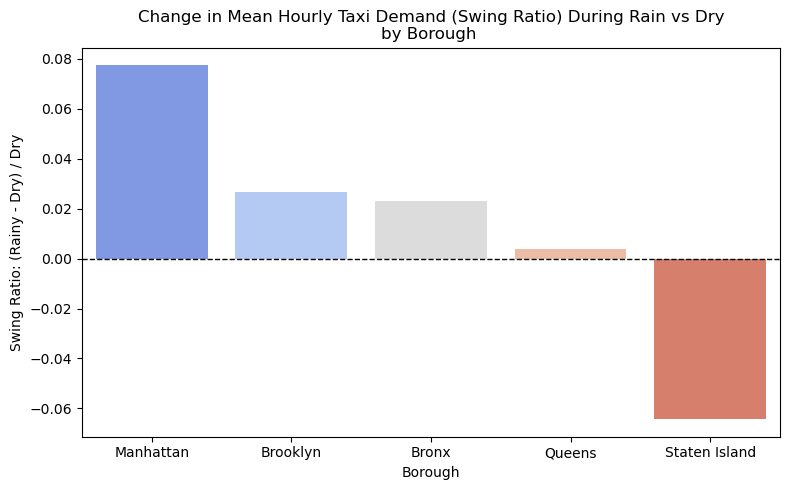

In [42]:
# Usage for all seasons (only borough and season, no other group columns)
SEASON = None

# Calculate swing ratio for each borough
borough_pivot = calculate_swing_ratio(
    taxi_weather_sdf,
    group_col="PUBorough",
    season=SEASON,
    weather_col="is_rain",
    weather_labels=("Dry", "Rainy"),
    agg_func="mean",
    borough_exclude=["EWR"],
)

# Convert to pandas for graphing
borough_pivot_pd = borough_pivot.select(
    "PUBorough", "Dry", "Rainy", "swing_ratio"
).toPandas()

borough_pivot_pd_sorted = borough_pivot_pd.sort_values("swing_ratio", ascending=False)


# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=borough_pivot_pd_sorted,
    x="PUBorough",
    y="swing_ratio",
    palette="coolwarm",
    hue=None,
)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.ylabel("Swing Ratio: (Rainy - Dry) / Dry")
plt.xlabel("Borough")
plt.title(
    f"Change in Mean Hourly Taxi Demand (Swing Ratio) During Rain vs Dry\nby Borough {SEASON if SEASON else ''}"
)
plt.tight_layout()

#### Map Swing Ratios

In [43]:
# Color gradients for orange (negative) and blue (positive)
ORANGE_GRADIENT = ["#fff5eb", "#fd8d3c", "#e6550d", "#a63603"]  
BLUE_GRADIENT = ["#e3f0fb", "#73b2ec", "#2d9cdc", "#1a64a4", "#00255c"]


In [ ]:
def prepare_zone_swing_data(
    taxi_weather_sdf,
    taxi_zones,
    season="Summer",
    borough="Manhattan",
    weather_col="is_rain",
    weather_labels=("Dry", "Rainy"),
    agg_func="mean",
):
    """
    Prepares swing data for a specific zone and weather conditions.
    Args:
        taxi_weather_sdf (DataFrame): The input DataFrame containing taxi and weather data.
        taxi_zones (GeoDataFrame): The GeoDataFrame containing taxi zone geometries.
        season (str): The season to filter the data (default: "Summer").
        borough (str): The borough to filter the data (default: "Manhattan").
        weather_col (str): The weather column to use for filtering (default: "is_rain").
        weather_labels (tuple): The labels for the weather categories (default: ("Dry", "Rainy")).
        agg_func (str): The aggregation function to use (default: "mean").
    Output: 
        GeoDataFrame: A GeoDataFrame containing the swing data for the specified zone and weather conditions.
    """

    # Calculate swing ratio for each zone
    zone_pivot = calculate_swing_ratio(
        taxi_weather_sdf,
        group_col="zone",
        season=season,
        borough=borough,
        weather_col=weather_col,
        weather_labels=weather_labels,
        agg_func=agg_func,
    )
    # Convert to pandas DataFrame and add borough
    zone_swing_pd = zone_pivot.select("zone", "swing_ratio").toPandas()
    borough_zones = taxi_zones[taxi_zones["borough"] == borough].copy()
    borough_zones = borough_zones.merge(zone_swing_pd, on="zone", how="left")
    return borough_zones

In [45]:
def plot_zone_swing_ratio_map(
    borough_zones,
    output_html="zone_swing_ratio_map.html",
    map_center=None,
    zoom_start=12,
    colormap_caption="Swing Ratio (Rainy vs Dry)",
    map_title="Manhattan Taxi Zone Swing Ratio (Rainy vs Dry)",
    season=None,
):
    """
    Plots a swing ratio map for NYC taxi zones using Folium.
    Params:
    - borough_zones: GeoDataFrame containing the borough taxi zones
    - output_html: Path for the output HTML file
    - map_center: Center location for the map (latitude, longitude)
    - zoom_start: Initial zoom level for the map
    - colormap_caption: Caption for the colormap legend
    - map_title: Title for the map
    - season: Optional season filter for the data
    """

    # Get min and max values for color scaling
    min_val = borough_zones["swing_ratio"].min()
    max_val = borough_zones["swing_ratio"].max()

    # Make the scale symmetric around zero for gradients
    abs_max = max(abs(min_val), abs(max_val))
    scale_min = -abs_max
    scale_max = abs_max

    # Create color steps for the colormap
    color_steps = ORANGE_GRADIENT[::-1] + ["#ffffff"] + BLUE_GRADIENT
    n_orange = len(ORANGE_GRADIENT)
    n_blue = len(BLUE_GRADIENT)

    # Create indices for the color steps
    indices = (
        list(np.linspace(scale_min, -1e-8, n_orange)) +
        [0, 1e-8] +
        list(np.linspace(1e-8, scale_max, n_blue))
    )

    # Create the colormap
    colormap = cm.StepColormap(
        colors=color_steps,
        vmin=scale_min,
        vmax=scale_max,
        index=indices,
        # caption=colormap_caption,
    )

    # Define the style function for the GeoJson layer
    def style_function(feature):
        # Get the swing ratio value
        value = feature["properties"]["swing_ratio"]
        if value is None or pd.isna(value):
            return {
                "fillColor": "#cccccc",
                "color": "#333333",
                "weight": 2,
                "fillOpacity": 0.3,
                "dashArray": "5, 5",
            }
        else:
            # Get the color for the swing ratio value
            color = colormap(value)
            # Return the style for the feature
            return {
                "fillColor": color,
                "color": "black",
                "weight": 1,
                "fillOpacity": 0.7,
            }

    # Add the tooltip
    tooltip = folium.features.GeoJsonTooltip(
        fields=["zone", "swing_ratio"],
        aliases=["Zone:", "Swing Ratio:"],
        localize=True,
        sticky=True,
        labels=True,
    )

    # Define title html and map size
    map_width = "700px"
    title_html = f"""
        <div style="display:inline-block;width:{map_width};padding:0;margin:0;">
            <div style="width:{map_width};margin:0;padding:0;">
                <h2 style="font-size:28px;margin:0;padding:0;text-align:center;">
                    <b>{map_title}{" - " + season if season else ""}</b>
                </h2>
            </div>
            <div style="height:10px;"></div>
        </div>
    """

    # Create map
    m = folium.Map(
        location=map_center,
        zoom_start=zoom_start,
        tiles="cartodbpositron",
        width=map_width,
        height=map_width,
    )

    # Add title
    m.get_root().html.add_child(folium.Element(title_html))
    folium.GeoJson(
        borough_zones, style_function=style_function, tooltip=tooltip, name="Zones"
    ).add_to(m)

    # Add colourmap
    colormap.add_to(m)
    # Add layer control
    folium.LayerControl().add_to(m)

    # Create output dir and save 
    os.makedirs(os.path.dirname(output_html), exist_ok=True)
    m.save(output_html)
    print(f"Map saved to {output_html}")

In [46]:
# Create map for median swing ratio in Fall
fall_zones = prepare_zone_swing_data(
    taxi_weather_sdf,
    taxi_zones,
    season="Fall",
    borough="Manhattan",
    weather_col="is_rain",
    weather_labels=("Dry", "Rainy"),
    agg_func="median",
)

# Plot the map
plot_zone_swing_ratio_map(
    fall_zones,
    output_html="../visualisations/manhattan_zone_swing_ratio_map_fall.html",
    map_center=COORD_DICT["Manhattan"],
    season="Fall",
)

# Create map for median swing ratio in Summer
all_zones = prepare_zone_swing_data(
    taxi_weather_sdf,
    taxi_zones,
    season=None,
    borough="Manhattan",
    weather_col="is_rain",
    weather_labels=("Dry", "Rainy"),
    agg_func="median",
)
plot_zone_swing_ratio_map(
    all_zones,
    output_html="../visualisations/manhattan_zone_swing_ratio_map_all.html",
    map_center=COORD_DICT["Manhattan"],
    season="All",
)


# Create map for is_extreme_cold in Manhattan
cold_zones = prepare_zone_swing_data(
    taxi_weather_sdf,
    taxi_zones,
    season=None,
    borough="Manhattan",
    weather_col="is_extreme_cold",
    weather_labels=("Not Extreme Cold", "Extreme Cold"),
    agg_func="median",
)
plot_zone_swing_ratio_map(
    cold_zones,
    output_html="../visualisations/manhattan_zone_swing_ratio_map_cold.html",
    map_center=COORD_DICT["Manhattan"],
    season="ALL",
)

Map saved to ../visualisations/manhattan_zone_swing_ratio_map_fall.html


Map saved to ../visualisations/manhattan_zone_swing_ratio_map_all.html
Map saved to ../visualisations/manhattan_zone_swing_ratio_map_cold.html


### Feature Engineering for Modelling 

In [47]:
final_sdf.columns

['LocationID',
 'pickup_datetime_hour',
 'trips',
 'total_fare_amount',
 'total_amount_sum',
 'median_total_amount',
 'mean_total_amount',
 'median_trip_distance',
 'mean_trip_distance',
 'median_trip_duration',
 'mean_trip_duration',
 'avg_passenger_count',
 'total_tip_amount',
 'total_tolls_amount',
 'total_extra',
 'total_improvement_surcharge',
 'total_mta_tax',
 'pct_within_borough_trip',
 'is_weekend',
 'season',
 'quarter',
 'pickup_hour',
 'week_of_year',
 'month',
 'day_of_week',
 'PUBorough',
 'zone',
 'hourly_ridership',
 'taxi_subway_ratio',
 'median_revenue_per_minute',
 'apparent_temperature',
 'cloud_cover',
 'direct_radiation',
 'is_day',
 'precipitation',
 'rain',
 'relative_humidity_2m',
 'shortwave_radiation',
 'snow_depth',
 'snowfall',
 'sunshine_duration',
 'surface_pressure',
 'temperature_2m',
 'timestamp',
 'weather_code',
 'wind_gusts_10m',
 'wind_speed_10m',
 'BoroName',
 'is_clear',
 'is_cloudy',
 'is_rain',
 'is_snow',
 'is_thunderstorm',
 'is_extreme_heat'

In [48]:
# Define weather columns to exclude from lagging
weather_cols = [
    "apparent_temperature",
    "cloud_cover",
    "direct_radiation",
    "is_day",
    "precipitation",
    "rain",
    "relative_humidity_2m",
    "shortwave_radiation",
    "snow_depth",
    "snowfall",
    "sunshine_duration",
    "surface_pressure",
    "temperature_2m",
    "weather_code",
    "wind_gusts_10m",
    "wind_speed_10m",
    "is_clear",
    "is_cloudy",
    "is_rain",
    "is_snow",
    "is_thunderstorm",
    "is_extreme_heat",
    "is_extreme_cold",
    "precip_intensity",
    "humidity_level",
    "is_windy",
]

# Exclude identifiers,timestamps
exclude_cols = set(
    weather_cols
    + [
        "pickup_datetime_hour",
        "LocationID",
        "zone",
        "PUBorough",
        "BoroName",
        "datetime_hour",
        "timestamp",
        "season",
        "is_weekend",
        "quarter",
        "pickup_hour",
        "week_of_year",
        "month",
        "day_of_week",
    ]
)

lag_cols = [c for c in final_sdf.columns if c not in exclude_cols]

# Window, partition by LocationID, order by pickup_datetime_hour
w = Window.partitionBy("LocationID").orderBy("pickup_datetime_hour")

# Add lag features for last 3 hours, last day (24h), last week (168h)
for colname in lag_cols:
    # Lag features
    final_sdf = final_sdf.withColumn(f"{colname}_lag1", F.lag(colname, 1).over(w))
    final_sdf = final_sdf.withColumn(f"{colname}_lag2", F.lag(colname, 2).over(w))
    final_sdf = final_sdf.withColumn(f"{colname}_lag3", F.lag(colname, 3).over(w))
    final_sdf = final_sdf.withColumn(f"{colname}_lag24", F.lag(colname, 24).over(w))
    final_sdf = final_sdf.withColumn(f"{colname}_lag168", F.lag(colname, 168).over(w))
    # Rolling averages (previous N rows, excludes current)
    w3 = w.rowsBetween(-3, -1)
    w24 = w.rowsBetween(-24, -1)
    w168 = w.rowsBetween(-168, -1)
    final_sdf = final_sdf.withColumn(f"{colname}_avg3", F.avg(colname).over(w3))
    final_sdf = final_sdf.withColumn(f"{colname}_avg24", F.avg(colname).over(w24))
    final_sdf = final_sdf.withColumn(f"{colname}_avg168", F.avg(colname).over(w168))


# Add growth count features for hourly_ridership and trips (previous hour minus the one before so no leakage)
final_sdf = final_sdf.withColumn(
    "hourly_ridership_growth_1h",
    F.col("hourly_ridership_lag1") - F.col("hourly_ridership_lag2"),
).withColumn("trips_growth_1h", F.col("trips_lag1") - F.col("trips_lag2"))


### Save Development Layer

Feature engineering and joins may have created nulls due to missing data. 
We want to represent these as 0 for modelling

In [49]:
# # Takes a while to run, uncomment if you would like to see where nulls are and why
# final_sdf = final_sdf.drop("swing_ratio")

# import sys
# sys.path.append("../functions")
# from processing import is_expected, report_null

# report_null(final_sdf, "final")

In [50]:
# Show rows in final_sdf where weather columns are null
weather_cols = ["apparent_temperature"]

null_condition = reduce(lambda a, b: a | b, [F.col(c).isNull() for c in weather_cols])
null_weather_rows = final_sdf.filter(null_condition)
null_weather_rows.count()

25/08/30 18:38:17 WARN TaskSetManager: Stage 232 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


4437

In [51]:
# Drop rows where weather is null (these are due to timezone mismatch, 2023 not in scope)
final_sdf = final_sdf.filter(F.col("apparent_temperature").isNotNull())

In [52]:
final_sdf.count()

25/08/30 18:38:18 WARN TaskSetManager: Stage 243 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


2288448

In [53]:
# Fill all nulls in lag/avg columns with 0 (they were created by missing data pre 2024)
# Justification in report
lag_avg_cols = [c for c in final_sdf.columns if "_lag" in c or "_avg" in c]
final_sdf = final_sdf.fillna({col: 0 for col in lag_avg_cols})

In [54]:
# Save final_sdf to parquet
OUTPUT_DIR = "../data/analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)
final_sdf.write.parquet(OUTPUT_DIR, mode="overwrite")

25/08/30 18:38:21 WARN TaskSetManager: Stage 254 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


### End Session

In [55]:
# Stop spark session
spark.stop()